## Dynamic Land Cover Mapping Service

In [32]:
import openeo
from openeo.extra.spectral_indices.spectral_indices import compute_and_rescale_indices
from openeo.processes import if_, is_nodata, array_concat, array_create
import geopandas as gpd
import pandas as pd
import json
from pathlib import Path
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay

In this notebook we will be studying land cover mapping. Land cover mapping has been done since the onset of remote sensing, and LC products have been identified as a fundamental variable needed for studying the functional and morphological changes occurring in the Earth's ecosystems and the environment, and plays therefore an important role in studying climate change and carbon circulation (Congalton et al., 2014; Feddema et al., 2005; Sellers et al., 1997). In addition to that, it provides valuable information for policy development and a wide range of applications within natural sciences and life sciences, making it one of the most widely studied applications within remote sensing (Yu et al., 2014, Tucker et al., 1985; Running, 2008; Yang et al., 2013).

With this variety in application fields comes a variety of user needs. Depending on the use case, there may be large differences in the target labels desired, the target year(s) requested, the output resolution needed, the featureset used, the stratification strategy employed, and more. The goal of this use case is to show that OpenEO as a platform can deal with this variability, and we will do so through creating a userfriendly interface in which the user can set a variety of parameters that will tailor the pipeline from -reference set & L2A+GRD > to model > to inference- to the users needs.

To see the most basic version of the dynamic land cover service, you can check out [this Python notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9.ipynb). If you'd like to have a look at some more advanced use cases, such as the use of stratification and the incorporation of extra datasets, have a look at [this Python notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9%20with%20stratification.ipynb). This last notebook will show features that we will not show in this tutorial.

In this notebook, helper functionality from [this repository](https://github.com/openEOPlatform/openeo-classification) is used. It contains amongst others the entire feature building engineering workflow, so if you are interested in knowing how to do that or if you want to make more customizations towards your own use case, have a look at it. Note that the repository is not finalized, as it is a general repository also used for other purposes.

![heelbelgie](https://user-images.githubusercontent.com/10434651/162210357-48389c4a-d58c-46da-972d-14f6ade2312e.png)

### Methodology

#### Reference data
The reference dataset used in this section is the Land Use/Cover Area frame Survey (LUCAS) Copernicus dataset of 2018. LUCAS is an evenly spaced in-situ land use and land cover ground survey exercise that extends over the entire of the European Union. The Copernicus module extends up to 51m in four cardinal directions to delineate polygons for each of these points. The final product contains about 60,000 polygons, from which subsequent points can be sampled (d'Andrimont et al., 2021). You as a user can specify how many points to sample from these polygons to train your model. In addition, the user can upload extra target data to improve performance.

#### Input data
The service created runs on features constructed from GRD sigma0 and L2A data. This data will be accessed through OpenEO platform from Terrascope and SentinelHub. You, as a user, can determine a time range, though the year should be kept to 2018, as that is the year in which the LUCAS Copernicus dataset was assembled. Data from other years can be extracted for prediction, provided that the user uploads their own reference set.

#### Preprocessing
The L2A data has been masked using the sen2cor sceneclassification, with a buffering approach developed at VITO and made available as a process called mask_scl_dilation. From the Sentinel-1 GRD collection, backscatter is calculated.


#### Feature engineering
We select and calculate the following products from our input collections:
- 7 indices (NDVI, NDMI, NDGI, ANIR, NDRE1, NDRE2, NDRE5) and 2 bands (B06, B12) from the L2A collection
- VV, VH and VV/VH (ratio) from the GRD sigma0 collection

As you user you are however free to select other S2 indices; if you are interested in doing so, please refer to the [advanced notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9%20with%20stratification.ipynb).

All layers are rescaled to 0 to 30000 for computational efficiency. The indices/bands are then aggregated temporally (for Sentinel-2 data: 10-day window using the median. For Sentinel-1 data: 12 day window using the mean. The median was used for the S2 collection instead of the mean to prevent possible artifacts caused by cloud shadows). The output is then interpolated linearly and the S1 cube is resampled spatially to a 10m resolution. Finally, 10 features are calculated on each of the band dimensions. These 10 features are the standard deviation, 25th, 50th and 75th percentile, and 6 equidistant t-steps. Through this procedure, we end up with a total of 120 features (12 bands x 10 features).

#### Model
Where previously models had to be trained outside of openEO, we can now train Random Forest models in openEO itself. Hyperparameter tuning can be performed using a custom hyperparameter set. After training, the model is validated and used for prediction.

### Implementation
First, we load in a dataset with target labels. In order for the model to work, the target labels need to be integers. Also, we extract some target points from the target polygons.

In [2]:
mask = box(4.4, 50.2, 5.6, 51.2)
y = gpd.read_file("https://artifactory.vgt.vito.be/auxdata-public/openeo/LUCAS_2018_Copernicus.gpkg",mask=mask)
y["geometry"] = y["geometry"].apply(lambda x: x.centroid)
y["LC1"] = y["LC1"].apply(lambda x: ord(x[0])-65)
y_train, y_test = train_test_split(y, test_size=0.25, random_state=333)

In [3]:
y_train["target"] = y_train.LC1
y_train = y_train[['target','geometry']]
y_test["target"] = y_test.LC1
y_test = y_test[['target','geometry']]
y_train

,target,geometry
104,4,POINT (5.06096 50.65388)
150,4,POINT (5.10580 50.22320)
105,1,POINT (5.05520 50.70752)
201,4,POINT (5.31993 50.89871)
30,1,POINT (4.60356 51.17385)
...,...,...
110,5,POINT (5.11171 50.70987)
179,4,POINT (5.24289 51.09367)
163,1,POINT (5.23653 50.31891)
205,1,POINT (5.42265 50.72273)


In [40]:
c = openeo.connect("openeo.cloud")
c.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeocloud.vito.be/openeo/1.0.0/' with OidcBearerAuth>

Next, we will create our featureset and use this featureset to train a model. The indices from which you calculate features can be adjusted by a parameter, but if you'd want you could even create the entire feature engineering pipeline yourself. If you are interested in knowing how to do so, you can dive a little bit deeper into the openEO code found [here](https://github.com/openEOPlatform/openeo-classification/blob/main/src/openeo_classification/features.py).

In [ ]:
def connection():
    return c



def sentinel2_composite(start_date, end_date, connection_provider, provider, index_dict=None, s2_list=[], processing_opts={}, sampling=False, stepsize=10, overlap=10, reducer="median", luc=False,cloud_procedure="sen2cor"):
    """
    Compute a cloud-masked, gap-filled, Sentinel-2 datacube, composited at 10-daily intervals.
    """
    temp_ext_s2 = [start_date.isoformat(), end_date.isoformat()]

    props = {
        "eo:cloud_cover": lambda v: v <= 80
    }
    
    bands = ["B03","B04","B05","B06","B07","B08","B11","B12","SCL"]

    c = connection_provider()
    s2 = c.load_collection("SENTINEL2_L2A",
                           temporal_extent=temp_ext_s2,
                           bands=bands,
                           properties=props)

    s2 = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL").filter_bands(s2.metadata.band_names[:-1])


    indices = compute_and_rescale_indices(s2, index_dict, True).filter_bands(s2_list + list(index_dict["indices"].keys()))
    idx_dekad = indices.aggregate_temporal_period("dekad",reducer="median")

    idx_dekad = idx_dekad.apply_dimension(dimension="t", process="array_interpolate_linear")    
    return idx_dekad




def sentinel1_composite(start_date, end_date, connection_provider = connection, provider = "Terrascope", processing_opts={}, relativeOrbit=None, orbitDirection = None, sampling=False, stepsize=12, overlap=6, reducer="mean"):
    c = connection_provider()
    temp_ext_s1 = [start_date.isoformat(), end_date.isoformat()]
    if (provider.upper() == "TERRASCOPE"):
        s1_id = "S1_GRD_SIGMA0_ASCENDING"
    else:
        s1_id = "SENTINEL1_GRD"
    properties = {}

    if orbitDirection is not None:
         properties["orbitDirection"] = lambda p: p == orbitDirection

    if provider.upper()=="SENTINELHUB":
         properties["polarization"] = lambda p: p == "DV"


    s1 = c.load_collection(s1_id,
                           temporal_extent=temp_ext_s1,
                           bands=["VH", "VV"],
                           properties=properties
                           )



    if (provider.upper() != "TERRASCOPE"):        
        s1 = s1.sar_backscatter(coefficient="sigma0-ellipsoid")

    # Observed Ranges:
    # VV: 0 - 0.3 - Db: -20 .. 0
    # VH: 0 - 0.3 - Db: -30 .. -5
    # Ratio: 0- 1
    #S1_GRD = S1_GRD.apply(lambda x: 10 * x.log(base=10))
    s1 = s1.apply_dimension(dimension="bands",
                            process=lambda x:array_create([30.0 * x[0] / x[1],30.0+10.0 * x[0].log(base=10),30.0+10.0*x[1].log(base=10)]))
    s1 = s1.rename_labels("bands", ["ratio"] + s1.metadata.band_names)
    # scale to int16
    s1 = s1.linear_scale_range(0, 30, 0,30000)
    s1_dekad = s1.aggregate_temporal_period(period="dekad", reducer="median")

    s1_dekad = s1_dekad.apply_dimension(dimension="t", process="array_interpolate_linear")
    return s1_dekad
        
def compute_statistics_fill_nan(base_features, start_date, end_date, stepsize):
    """
    Computes statistics over a datacube.
    For correct statistics, the datacube needs to be preprocessed to contain observation at equitemporal intervals, without nodata values.

    """
    def computeStats(input_timeseries, sample_stepsize, offset):
        tsteps = list([input_timeseries.array_element(offset + sample_stepsize * index) for index in range(0, 6)])
        tsteps[1] = if_(is_nodata(tsteps[1]), tsteps[2], tsteps[1])
        tsteps[4] = if_(is_nodata(tsteps[4]), tsteps[3], tsteps[4])
        tsteps[0] = if_(is_nodata(tsteps[0]), tsteps[1], tsteps[0])
        tsteps[5] = if_(is_nodata(tsteps[5]), tsteps[4], tsteps[5])
        return array_concat(
            array_concat(input_timeseries.quantiles(probabilities=[0.25, 0.5, 0.75]), input_timeseries.sd()), tsteps)

    tot_samples = (end_date - start_date).days // stepsize
    nr_tsteps = 6
    sample_stepsize = tot_samples // nr_tsteps
    offset = int(sample_stepsize/2 + (tot_samples%nr_tsteps)/2)

    features = base_features.apply_dimension(dimension='t', target_dimension='bands', process=lambda x: computeStats(x, sample_stepsize, offset))
    
    tstep_labels = ["t" + str(offset + sample_stepsize * index) for index in range(0, 6)]
    all_bands = [band + "_" + stat for band in base_features.metadata.band_names for stat in
                 ["p25", "p50", "p75", "sd"] + tstep_labels]
    features = features.rename_labels('bands', all_bands)
    return features


def load_lc_features(provider, feature_raster, start_date, end_date, stepsize_s2=10, stepsize_s1=12, processing_opts={}, index_dict=None,connection_provider = connection):

    if not index_dict:
        idx_list = ["NDVI", "NDMI", "NDGI", "NDRE1", "NDRE2", "NDRE5"]
        s2_list = ["B06", "B12"]
        index_dict = {idx: [-1,1] for idx in idx_list}
        index_dict["ANIR"] = [0,1]

    final_index_dict = {
        "collection": {
            "input_range": [0, 8000],
            "output_range": [0, 30000]
        },
        "indices": {
            index: {"input_range": index_dict[index], "output_range": [0, 30000]} for index in index_dict
        }
    }

    idx_dekad = sentinel2_composite(start_date, end_date, connection_provider, provider, final_index_dict, s2_list, processing_opts=processing_opts, sampling=True, stepsize=stepsize_s2, luc=True)
    idx_features = compute_statistics_fill_nan(idx_dekad, start_date, end_date, stepsize=stepsize_s2)

    s1_dekad = sentinel1_composite(start_date, end_date, connection_provider, provider, processing_opts=processing_opts, orbitDirection="ASCENDING", sampling=True, stepsize=stepsize_s1)
    s1_dekad = s1_dekad.resample_cube_spatial(idx_dekad)
    s1_features = compute_statistics_fill_nan(s1_dekad, start_date, end_date, stepsize=stepsize_s1)

    features = idx_features.merge_cubes(s1_features)
    
    return features, features.metadata.band_names

In [23]:
features, feature_list = load_lc_features("terrascope", "both", datetime.date(2018, 3, 1), datetime.date(2018, 10, 31))
X = features.aggregate_spatial(json.loads(y_train.to_json()), reducer="mean")
ml_model = X.fit_class_random_forest(target=json.loads(y_train.to_json()), num_trees=200)
model = ml_model.save_ml_model()

In [38]:
training_job = model.create_job()
training_job.start_and_wait()

0:00:00 Job 'j-447225d3eff64c4a85deb43e81b0dac0': send 'start'
0:00:50 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:00:55 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:01:02 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:01:10 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:01:21 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:01:33 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:01:49 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:02:09 Job 'j-447225d3eff64c4a85deb43e81b0dac0': queued (progress N/A)
0:02:33 Job 'j-447225d3eff64c4a85deb43e81b0dac0': running (progress N/A)
0:03:04 Job 'j-447225d3eff64c4a85deb43e81b0dac0': running (progress N/A)
0:03:41 Job 'j-447225d3eff64c4a85deb43e81b0dac0': running (progress N/A)
0:04:29 Job 'j-447225d3eff64c4a85deb43e81b0dac0': running (progress N/A)
0:05:27 Job 'j-447225d3eff64c4a85deb43e81b0dac0': running (progress N

<RESTJob job_id='j-447225d3eff64c4a85deb43e81b0dac0'>

In [16]:
r.download_files()

[PosixPath('/data/users/Public/driesj/openeo/sample-notebooks/randomforest.model.tar.gz'),
 PosixPath('/data/users/Public/driesj/openeo/sample-notebooks/job-results.json')]

In [41]:
training_job = c.job("j-447225d3eff64c4a85deb43e81b0dac0")

Subsequently, we can calculate a number of validation metrics from our test set. To do so, we do inference for the points of our y-test set and write these predictions out to a netCDF. The function `calculate_validation_metrics` (not part of openEO itself, but simply a client-side helper function) then loads in the y-test geojson and the netCDF with predicted values, extracts the points and stores the predicted values alongside their actual target labels in a dataframe.

In [42]:
base_path = Path.cwd() / "results" / "testarea"
validation_path = base_path / "validation"
validation_path.mkdir(parents=True,exist_ok=True)

y_test.to_file(filename=str(validation_path / 'y_test.geojson'),driver="GeoJSON")
cube = features
predicted = cube.predict_random_forest(model=training_job, dimension="bands").linear_scale_range(0,255,0,255).aggregate_spatial(json.loads(y_test.to_json()), reducer="mean")#"https://github.com/openEOPlatform/sample-notebooks/raw/main/resources/landcover/model_item.json"
test_job = predicted.execute_batch(out_format="CSV")
test_job.get_results().download_files(str(validation_path))



0:00:00 Job 'j-b8551908db3b46baa162b4a37dd3713e': send 'start'
0:02:05 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:02:10 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:02:17 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:02:25 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:02:36 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:02:48 Job 'j-b8551908db3b46baa162b4a37dd3713e': queued (progress N/A)
0:03:04 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:03:24 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:03:48 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:04:18 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:04:56 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:05:43 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress N/A)
0:06:42 Job 'j-b8551908db3b46baa162b4a37dd3713e': running (progress

[PosixPath('/home/jovyan/work/results/testarea/validation/timeseries.csv'),
 PosixPath('/home/jovyan/work/results/testarea/validation/job-results.json')]

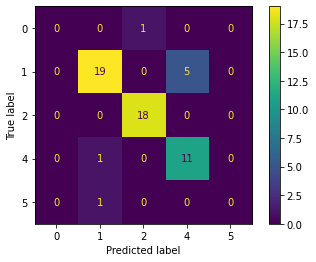

In [43]:
df= pd.read_csv(validation_path / "timeseries.csv")
df.index = df.feature_index
df=df.sort_index()
df.columns = ["feature_index","predicted"]

gdf = gpd.read_file(validation_path / 'y_test.geojson')
gdf['predicted'] = df.predicted.astype(int)

ConfusionMatrixDisplay.from_predictions(gdf["target"],gdf["predicted"])


In [44]:
accuracy_score(gdf["target"],gdf["predicted"])

0.8571428571428571

After inspecting the metrics and possibly further finetuning the model or dataset, we can do inference on an area of choice and write the result out to a netCDF or GTiff. Happy mapping!

In [45]:
features, feature_list = load_lc_features("terrascope", "both", datetime.date(2018, 3, 1), datetime.date(2018, 10, 31), processing_opts=dict(tile_size=256))

cube = features.filter_bbox({
    'west':5.1,'east':5.2,'south':50.7,'north':50.8
})
predicted = cube.predict_random_forest(
    model=training_job,
    dimension="bands"
).linear_scale_range(0,255,0,255)
inf_job = predicted.execute_batch(out_format="GTiff")
inf_job.get_results().download_files(str(base_path / "prediction"))

0:00:00 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': send 'start'
0:00:53 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': queued (progress N/A)
0:01:00 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': queued (progress N/A)
0:01:07 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': queued (progress N/A)
0:01:16 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': queued (progress N/A)
0:01:27 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': queued (progress N/A)
0:01:40 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:01:57 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:02:17 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:02:41 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:03:12 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:03:51 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0:04:40 Job 'vito-j-f389f2a62fc64a5ca289f4fde6676a54': running (progress N/A)
0

[PosixPath('/home/jovyan/work/results/testarea/prediction/openEO.tif'),
 PosixPath('/home/jovyan/work/results/testarea/prediction/job-results.json')]

![tile31UFS](https://user-images.githubusercontent.com/10434651/162389189-f20d8b4d-6509-4965-bf13-60590438d75c.png)